![MuJoCo banner](https://raw.githubusercontent.com/google-deepmind/mujoco/main/banner.png)

# <h1><center>LQR tutorial  <a href="https://colab.research.google.com/github/google-deepmind/mujoco/blob/main/python/LQR.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" width="140" align="center"/></a></center></h1>

This notebook provides an example of an LQR controller using [**MuJoCo** physics](https://github.com/google-deepmind/mujoco#readme).

### Copyright notice

> <p><small><small>Copyright 2022 DeepMind Technologies Limited</small></p>
> <p><small><small>Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at <a href="http://www.apache.org/licenses/LICENSE-2.0">http://www.apache.org/licenses/LICENSE-2.0</a>.</small></small></p>
> <p><small><small>Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.</small></small></p>

## All imports


In [1]:

# Set up GPU rendering.
#from google.colab import files
import distutils.util
import os
import subprocess
import mujoco


# Other imports and helper functions
import numpy as np
from typing import Callable, Optional, Union, List
import scipy.linalg
import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

from IPython.display import clear_output
clear_output()


## Load and render the standard humanoid

In [2]:
#print('Getting MuJoCo humanoid XML description from GitHub:')
#!git clone https://github.com/google-deepmind/mujoco
#!git clone https://github.com/google-deepmind/mujoco_menagerie

The XML is used to instantiate an `MjModel`. Given the model, we can create an `MjData` which holds the simulation state, and an instance of the `Renderer` class defined above.

In [3]:
model = mujoco.MjModel.from_xml_string(open('/Users/ladislavtopfer/Desktop/Princeton/Thesis/agility_cassie/scene.xml').read())


data = mujoco.MjData(model)
renderer = mujoco.Renderer(model)

The state in the `data` object is in the default configuration. Let's invoke the forward dynamics to populate all the derived quantities (like the positions of geoms in the world), update the scene and render it:

""

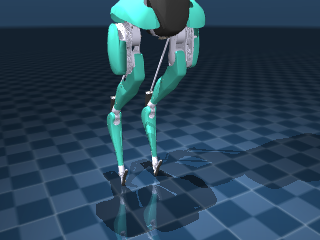

In [4]:
mujoco.mj_forward(model, data)
renderer.update_scene(data)
media.show_image(renderer.render())

The model comes with some built-in "keyframes" which are saved simulation states.

`mj_resetDataKeyframe` can be used to load them. Let's see what they look like:

In [5]:
print(model.nkey)
print(data.qpos)

1
[ 0.     0.     1.1    1.     0.     0.     0.     0.     0.     0.     1.     0.     0.     0.
 -0.785  0.     1.012  0.     0.     0.     0.     0.     0.     0.     1.     0.     0.     0.
 -0.785  0.     1.012  0.     0.     0.     0.   ]


0


""

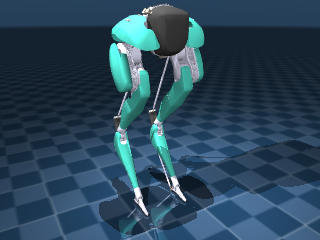

In [6]:
for key in range(model.nkey):
  print(key)
  mujoco.mj_resetDataKeyframe(model, data, key)
  mujoco.mj_forward(model, data)
  renderer.update_scene(data)
  media.show_image(renderer.render())

Now let's simulate the physics and render to make a video.

In [7]:
DURATION  = 3   # seconds
FRAMERATE = 60  # Hz

# Initialize to the standing-on-one-leg pose.
mujoco.mj_resetDataKeyframe(model, data, 0)

frames = []
while data.time < DURATION:
  # Step the simulation.
  mujoco.mj_step(model, data)

  # Render and save frames.
  if len(frames) < data.time * FRAMERATE:
    renderer.update_scene(data)
    pixels = renderer.render()
    frames.append(pixels)

# Display video.
media.show_video(frames, fps=FRAMERATE)

The model defines built-in torque actuators which we can use to drive the humanoid's joints by setting the `data.ctrl` vector. Let's see what happens if we inject noise into it.

While we're here, let's use a custom camera that will track the humanoid's center of mass.

In [8]:
DURATION  = 3   # seconds
FRAMERATE = 60  # Hz

# Make a new camera, move it to a closer distance.
camera = mujoco.MjvCamera()
mujoco.mjv_defaultFreeCamera(model, camera)
camera.distance = 2

mujoco.mj_resetDataKeyframe(model, data, 0)
i=0
frames = []
while data.time < DURATION:
  # Set control vector.
  data.ctrl = np.random.randn(model.nu)

  # Step the simulation.
  mujoco.mj_step(model, data)


  """ if (i % 60 == 0):
    print(i)
    renderer.update_scene(data)
    media.show_image(renderer.render()) 

  i += 1 """

  # Render and save frames.
  if len(frames) < data.time * FRAMERATE:
    # Set the lookat point to the humanoid's center of mass.
    camera.lookat = data.body('cassie-pelvis').subtree_com

    renderer.update_scene(data, camera)
    pixels = renderer.render()
    frames.append(pixels)

media.show_video(frames, fps=FRAMERATE)

## Stable standing on one leg

Clearly this initial pose is not stable. We'll try to find a stabilising control law using a [Linear Quadratic Regulator](https://en.wikipedia.org/wiki/Linear%E2%80%93quadratic_regulator).

### Recap of LQR theory
There are many online resources explaining this theory, developed by Rudolph Kalman in the 1960s, but we'll provide a minimal recap.

Given a dynamical system which is linear in the state $x$ and control $u$,
$$
x_{t+h} = A x_t + B u_t
$$
if the system fulfills a controllability criterion, it is possible to stabilize it (drive $x$ to 0) in an optimal fashion, as follows. Define a quadratic cost function over states and controls $J(x,u)$ using two Symmetric Positive Definite matrices $Q$ and $R$:
$$
J(x,u) = x^T Q x + u^T R u
$$

The cost-to-go $V^\pi(x_0)$, also known as the Value function, is the total sum of future costs, letting the state start at $x_0$ and evolve according to the dynamics, while using a control law $u=\pi(x)$:
$$
V^\pi(x_0) = \sum_{t=0}^\infty J(x_t, \pi(x_t))
$$
Kalman's central result can now be stated. The optimal control law which minimizes the cost-to-go (over all possible control laws!) is linear
$$
\pi^*(x) = \underset{\pi}{\text{argmin}}\; V^\pi(x)=-Kx
$$
and the optimal cost-to-go is quadratic
$$
V^*(x) =\underset{\pi}{\min}\; V^\pi(x) = x^T P x
$$
The matrix $P$ obeys the Riccati equation
$$
P = Q + A^T P A - A^T P B (R+B^T P B)^{-1} B^T P A
$$
and its relationship to the control gain matrix $K$ is
$$
K = (R + B^T  P B)^{-1} B^T P A
$$

### Understanding linearization setpoints

Of course our humanoid simulation is anything but linear. But while MuJoCo's `mj_step` function computes some non-linear dynamics $x_{t+h} = f(x_t,u_t)$, we can *linearize* this function around any state-control pair. Using shortcuts for the next state $y=x_{t+h}$, the current state $x=x_t$ and the current control $u=u_t$, and using $\delta$ to mean "small change in", we can write
$$
\delta y = \frac{\partial f}{\partial x}\delta x+ \frac{\partial f}{\partial u}\delta u
$$
In other words, the partial derivative matrices decribe a linear relationship between perturbations to $x$ and $u$ and changes to $y$. Comparing to the theory above, we can identify the partial derivative (Jacobian) matrices with the transition matrices $A$ and $B$, when considering the linearized dynamical system:
$$
A = \frac{\partial f}{\partial x} \quad
B = \frac{\partial f}{\partial u}
$$
In order to perform the linearization, we need to choose some setpoints $x$ and $u$ around which we will linearize. We already know $x$, this is our initial pose of standing on one leg. But what about $u$? How do we find the "best" control around which to linearise?

The answer is inverse dynamics.

### Finding the control setpoint using inverse dynamics

MuJoCo's forward dynamics function `mj_forward`, which we used above in order to propagate derived quantities, computes the acceleration given the state and all the forces in the system, some of which are created by the actuators.

The inverse dynamics function takes the acceleration as *input*, and computes the forces required to create the acceleration. Uniquely, MuJoCo's [fast inverse dynamics](https://doi.org/10.1109/ICRA.2014.6907751) takes into account all constraints, including contacts. Let's see how it works.

We'll call the forward dynamics at our desired position setpoint, set the acceleration in `data.qacc` to 0, and call the inverse dynamics:

In [9]:
mujoco.mj_resetDataKeyframe(model, data, 0)
mujoco.mj_forward(model, data)
data.qacc = 0  # Assert that there is no the acceleration.
mujoco.mj_inverse(model, data)
print(data.qfrc_inverse)

[  0.      0.     -0.017   0.039   4.401  -0.      1.863  -0.035  -7.71   -0.      0.042  -0.213
   5.413   7.43  -34.313   5.436 -18.375   0.185  16.027  -1.86    0.035  -7.71    0.     -0.037
  -0.202   5.407   7.427 -34.307   5.444 -18.375   0.185  16.027]


In [10]:
mujoco.mj_resetDataKeyframe(model, data, 0)
mujoco.mj_forward(model, data)
data.qacc = 0
qpos0 = data.qpos.copy()  # Save the position setpoint.
mujoco.mj_inverse(model, data)
qfrc0 = data.qfrc_inverse.copy()
print('desired forces:', qfrc0)

desired forces: [  0.      0.     -0.017   0.039   4.401  -0.      1.863  -0.035  -7.71   -0.      0.042  -0.213
   5.413   7.43  -34.313   5.436 -18.375   0.185  16.027  -1.86    0.035  -7.71    0.     -0.037
  -0.202   5.407   7.427 -34.307   5.444 -18.375   0.185  16.027]


Much better, the forces on the root joint are small. Now that we have forces that can reasonably be produced by the actuators, how do we find the actuator values that will create them? For simple `motor` actuators like the humanoid's, we can simply "divide" by the actuation moment arm matrix, i.e. multiply by its pseudo-inverse:

In [11]:
ctrl0 = np.atleast_2d(qfrc0) @ np.linalg.pinv(data.actuator_moment)
ctrl0 = ctrl0.flatten()  # Save the ctrl setpoint.
print('control setpoint:', ctrl0)
#ctrl0[2] = -0.1
#ctrl0[7] = -0.1
print('control setpoint:', ctrl0)

control setpoint: [ 0.075 -0.001 -0.482  0.338  0.321 -0.074  0.001 -0.482  0.338  0.321]
control setpoint: [ 0.075 -0.001 -0.482  0.338  0.321 -0.074  0.001 -0.482  0.338  0.321]


More elaborate actuators would require a different method to recover $\frac{\partial \texttt{ qfrc_actuator}}{\partial \texttt{ ctrl}}$, and finite-differencing is always an easy option.

Let's apply these controls in the forward dynamics and compare the forces they produce with the desired forces printed above:

In [12]:
data.ctrl = ctrl0
mujoco.mj_forward(model, data)
print('actuator forces:', data.qfrc_actuator)

actuator forces: [ 0.     0.     0.     0.     0.     0.     1.863 -0.035 -7.71   0.     0.     0.     5.413  0.
  0.     0.     0.     0.    16.027 -1.86   0.035 -7.71   0.     0.     0.     5.407  0.     0.
  0.     0.     0.    16.027]


Because the humanoid is fully-actuated (apart from the root joint), and the required forces are all within the actuator limits, we can see a perfect match with the desired forces across all internal joints. There is still some mismatch in the root joint, but it's small. Let's see what the simulation looks like when we apply these controls:

""

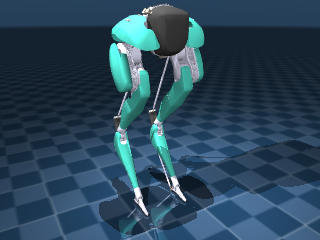

In [23]:
DURATION  = 2   # seconds
FRAMERATE = 60  # Hz

# Set the state and controls to their setpoints.
mujoco.mj_resetDataKeyframe(model, data, 0)
#data.qpos = qpos0
data.ctrl = ctrl0
mujoco.mj_forward(model, data)
renderer.update_scene(data)
media.show_image(renderer.render())

frames = []
i = 0
while data.time < DURATION:
  # Step the simulation.
  mujoco.mj_step(model, data)
  

  """ if (i % 60 == 0):
    print(i)
    renderer.update_scene(data)
    media.show_image(renderer.render()) 

  i += 1 """

  # Render and save frames.
  if len(frames) < data.time * FRAMERATE:
    # Set the lookat point to the humanoid's center of mass.
    camera.lookat = data.body('cassie-pelvis').subtree_com
    renderer.update_scene(data, camera)
    pixels = renderer.render()
    frames.append(pixels)

media.show_video(frames, fps=FRAMERATE)

Comparing to the completely passive video we made above, we can see that this is a much better control setpoint. The humanoid still falls down, but it tries to stabilize and succeeds for a short while.

### Choosing the $Q$ and $R$ matrices

In order to obtain the LQR feedback control law, we will need to design the $Q$ and $R$ matrices. Due to the linear structure, the solution is invariant to a scaling of both matrices, so without loss of generality we can choose $R$ to be the identity matrix:

In [24]:
nu = model.nu  # Alias for the number of actuators.
R = np.eye(nu)

Choosing $Q$ is more elaborate. We will construct it as a sum of two terms.

First, a balancing cost that will keep the center of mass (CoM) over the foot. In order to describe it, we will use kinematic Jacobians which map between joint space and global Cartesian positions. MuJoCo computes these analytically.

In [25]:
nv = model.nv  # Shortcut for the number of DoFs.

# Get the Jacobian for the root body (torso) CoM.
mujoco.mj_resetData(model, data)
data.qpos = qpos0
mujoco.mj_forward(model, data)
jac_com = np.zeros((3, nv))
mujoco.mj_jacSubtreeCom(model, data, jac_com, model.body('cassie-pelvis').id)

# Get the Jacobian for the left foot.
jac_foot = np.zeros((3, nv))
mujoco.mj_jacBodyCom(model, data, jac_foot, None, model.body('left-foot').id)

jac_diff = jac_com - jac_foot
Qbalance = jac_diff.T @ jac_diff

Second, a cost for joints moving away from their initial configuration. We will want different coefficients for different sets of joints:
- The free joint will get a coefficient of 0, as that is already taken care of by the CoM cost term.
- The joints required for balancing on the left leg, i.e. the left leg joints and the horizontal abdominal joints, should stay quite close to their initial values.
- All the other joints should have a smaller coefficient, so that the humanoid will, for example, be able to flail its arms in order to balance.

Let's get the indices of all these joint sets.



In [50]:
# Get all joint names.
joint_names = [model.joint(i).name for i in range(model.njnt)]

# Get indices into relevant sets of joints.
body_dofs = range(0, nv)
leg_dofs = [
    model.joint(name).dofadr[0]
    for name in joint_names
    if ('shin' in name or 'tarsus' in name or 'heel-spring' in name or 'foot-crank' in name or 'plantar-rod' in name or 'foot' in name or 'hip-pitch' in name)
]
balance_dofs = leg_dofs
other_dofs = np.setdiff1d(body_dofs, balance_dofs)

In [51]:
leg_dofs

[8, 13, 14, 15, 16, 17, 18, 21, 26, 27, 28, 29, 30, 31]

In [32]:
body_dofs

range(0, 32)

In [33]:
other_dofs

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 19, 20, 21, 22, 23, 24, 25])

In [17]:
joint_names

['',
 'left-hip-roll',
 'left-hip-yaw',
 'left-hip-pitch',
 'left-achilles-rod',
 'left-knee',
 'left-shin',
 'left-tarsus',
 'left-heel-spring',
 'left-foot-crank',
 'left-plantar-rod',
 'left-foot',
 'right-hip-roll',
 'right-hip-yaw',
 'right-hip-pitch',
 'right-achilles-rod',
 'right-knee',
 'right-shin',
 'right-tarsus',
 'right-heel-spring',
 'right-foot-crank',
 'right-plantar-rod',
 'right-foot']

We are now ready to construct the Q matrix. Note that the coefficient of the balancing term is quite high. This is due to 3 separate reasons:
- It's the thing we care about most. Balancing means keeping the CoM over the foot.
- We have less control authority over the CoM (relative to body joints).
- In the balancing context, units of length are "bigger". If the knee bends by 0.1 radians (≈6°), we can probably still recover. If the CoM position is 10cm sideways from the foot position, we are likely on our way to the floor.

In [57]:
# Cost coefficients.
BALANCE_COST        = 1000  # Balancing.
BALANCE_JOINT_COST  = 3     # Joints required for balancing.
OTHER_JOINT_COST    = .3    # Other joints.

# Construct the Qjoint matrix.
Qjoint = np.eye(nv)
#Qjoint[balance_dofs, balance_dofs] *= BALANCE_JOINT_COST
#Qjoint[other_dofs, other_dofs] *= OTHER_JOINT_COST
Qjoint[body_dofs, body_dofs] *= BALANCE_JOINT_COST

# Construct the Q matrix for position DoFs.
Qpos = BALANCE_COST * Qbalance + Qjoint

# No explicit penalty for velocities.
Q = np.block([[Qpos, np.zeros((nv, nv))],
              [np.zeros((nv, 2*nv))]])

In [58]:
Q

array([[3., 0., 0., ..., 0., 0., 0.],
       [0., 3., 0., ..., 0., 0., 0.],
       [0., 0., 3., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

### Computing the LQR gain matrix $K$

Before we solve for the LQR controller, we need the $A$ and $B$ matrices. These are computed by MuJoCo's `mjd_transitionFD` function which computes them using efficient finite-difference derivatives, exploiting the configurable computation pipeline to avoid recomputing quantities which haven't changed.

In [59]:
# Set the initial state and control.
mujoco.mj_resetData(model, data)
data.ctrl = ctrl0
data.qpos = qpos0

# Allocate the A and B matrices, compute them.
A = np.zeros((2*nv, 2*nv))
B = np.zeros((2*nv, nu))
epsilon = 1e-6
flg_centered = True
mujoco.mjd_transitionFD(model, data, epsilon, flg_centered, A, B, None, None)

We are now ready to solve for our stabilizing controller. We will use `scipy`'s `solve_discrete_are` to solve the Riccati equation and get the feedback gain matrix using the formula described in the recap.

In [60]:
# Solve discrete Riccati equation.
P = scipy.linalg.solve_discrete_are(A, B, Q, R)

# Compute the feedback gain matrix K.
K = np.linalg.inv(R + B.T @ P @ B) @ B.T @ P @ A

In [21]:
#X0 =
#U0 = ctrl0

#X, U, K_closed, k_open = solve_ilqr(X0, U0, qpos0, 1/60, Q, R)

### Stable standing

We can now try our stabilising controller.

Note that in order to apply our gain matrix $K$, we need to use `mj_differentiatePos` which computes the difference of two positions. This is important because the root orientation is given by a length-4 quaternion, while the difference of two quaternions (in the tangent space) is length-3. In MuJoCo notation, positions (`qpos`) are of size `nq` while a position differences (and velocities) are of size `nv`.


In [62]:
# Parameters.
DURATION = 5          # seconds
FRAMERATE = 120        # Hz

# Reset data, set initial pose.
mujoco.mj_resetData(model, data)
data.qpos = qpos0

# Allocate position difference dq.
dq = np.zeros(model.nv)

frames = []
while data.time < DURATION:
  # Get state difference dx.
  mujoco.mj_differentiatePos(model, dq, 1, qpos0, data.qpos)
  dx = np.hstack((dq, data.qvel)).T

  # LQR control law.
  data.ctrl = ctrl0 - K @ dx

  # Step the simulation.
  mujoco.mj_step(model, data)

  # Render and save frames.
  if len(frames) < data.time * FRAMERATE:
    renderer.update_scene(data)
    pixels = renderer.render()
    frames.append(pixels)

media.show_video(frames, fps=FRAMERATE)

# Generate iLQR control

# Cost and cost derivates

In [ ]:
def calculate_cost(X, U, target, SigmaX, SigmaY):
    '''
    Obtain the cost along the trajectory
    Param:
      X: 4xN matrix of trajectory, with each slice [X, Y, v_X, v_Y]
      U: 2xN matrix of control sequence, with each slice [F, phi]
      target: 4d vector of target state [X, Y, v_X, v_Y]
      SigmaX: 4x4 matrix of state error weight
      SigmaY: 2x2 matrix of control weight
    '''
    T = X.shape[1]
    error = X - target[:,np.newaxis]
    u_ref = np.array([m*g,0])
    c = np.zeros(T)
    for t in range(T):
        c_state = error[:,t].T@SigmaX@error[:,t]
        c_control = (U[:,t]-u_ref).T@SigmaY@(U[:,t]-u_ref)
        c[t] = 0.5*(c_state+c_control)
    J = np.sum(c)
    return J, c

In [ ]:
def calculate_cost_deri(X, U, target, SigmaX, SigmaY):
    '''
    obtain the jacobian and hessian of the cost along the trajectory
    Param:
      X: 4xN matrix of trajectory, with each slice [X, Y, v_X, v_Y]
      U: 2xN matrix of control sequence, with each slice [F, phi]
      target: 4d vector of target state [X, Y, v_X, v_Y]
      SigmaX: 4x4 matrix of state error weight
      SigmaY: 2x2 matrix of control weight
    '''
    T = X.shape[1]

    error = X-target[:,np.newaxis]
    u_ref = np.array([m*g,0])

    q = np.zeros((4,T))
    r = np.zeros((2,T))
    Q = np.zeros((4,4,T))
    R = np.zeros((2,2,T))
    H = np.zeros((2,4,T))
    for t in range(T):
        q[:,t] = SigmaX@error[:,t]
        Q[:,:,t] = SigmaX
        r[:,t] = SigmaY@(U[:,t]-u_ref)
        R[:,:,t] = SigmaY

    return q, r, Q, R, H

# Backwards pass

In [ ]:
def backward_pass(X, U, target, dt, SigmaX, SigmaY, reg=1):
    '''
    calculate backward pass in iLQR
    '''
    q, r, Q, R, H = calculate_cost_deri(X, U, target, SigmaX, SigmaY)

    T = X.shape[1]

    k_open_loop = np.zeros((2, T))
    K_closed_loop = np.zeros((2, 4, T))
    # derivative of value function at final step
    p = q[:,T-1]
    P = Q[:,:,T-1]
    t = T-2

    while t>=0:
        Q_x = q[:,t] + A[:,:,t].T @ p
        Q_u = r[:,t] + B[:,:,t].T @ p
        Q_xx = Q[:,:,t] + A[:,:,t].T @ P @ A[:,:,t]
        Q_uu = R[:,:,t] + B[:,:,t].T @ P @ B[:,:,t]
        Q_ux = H[:,:,t] + B[:,:,t].T @ P @ A[:,:,t]

        # Add regularization
        reg_matrix = reg*np.eye(4)
        Q_uu_reg = R[:,:,t] + B[:,:,t].T @ (P+reg_matrix) @ B[:,:,t]
        Q_ux_reg = H[:,:,t] + B[:,:,t].T @ (P+reg_matrix) @ A[:,:,t]

        # check if Q_uu_reg is PD
        if not np.all(np.linalg.eigvals(Q_uu_reg) > 0) and reg < 1e5:
          reg *= 5
          t = T-2
          p = q[:,T-1]
          P = Q[:,:,T-1]
          continue

        Q_uu_reg_inv = np.linalg.inv(Q_uu_reg)
        # Calculate policy
        k = -Q_uu_reg_inv@Q_u
        K = -Q_uu_reg_inv@Q_ux_reg
        k_open_loop[:,t] = k
        K_closed_loop[:, :, t] = K

        # Update value function derivative for the previous time step
        p = Q_x + K.T @ Q_uu @ k + K.T@Q_u + Q_ux.T@k
        P = Q_xx + K.T @ Q_uu @ K + K.T@Q_ux + Q_ux.T@K
        t -= 1
    reg = max(1e-5, reg*0.5)
    return K_closed_loop, k_open_loop, reg

# Forward pass

In [ ]:
def roll_out(X_0, U_0, K_closed_loop, k_open_loop, alpha, dt):
    X = np.zeros_like(X_0)
    U = np.zeros_like(U_0)

    X[:,0] = X_0[:,0]
    T = X_0.shape[1]
    for t in range(T-1):
        K = K_closed_loop[:,:,t]
        k = k_open_loop[:,t]
        U[:,t] = U_0[:,t]+alpha*k+ K @ (X[:, t] - X_0[:, t])
        data.ctrl = U
        mujoco.mj_step(model, data)
        X[:,t+1] = data.qpos

    return X, U

# Solve iLQR

In [ ]:
def solve_ilqr(X, U, target, dt, SigmaX, SigmaY):
    reg = 1
    steps = 100

    #initial step
    J, _ = calculate_cost(X, U, target, SigmaX, SigmaY)

    converged = False
    for i in range(steps):
        alpha = 1
        K_closed_loop, k_open_loop, reg = backward_pass(X, U, target, dt, SigmaX, SigmaY, reg)
        changed = False
        for _ in range(3) :
            X_new, U_new = roll_out(X, U, K_closed_loop, k_open_loop, alpha, dt)
            J_new, _ = calculate_cost(X_new, U_new, target, SigmaX, SigmaY)
            if J_new<=J:
                if np.abs(J - J_new) < 1e-3:
                    converged = True
                J = J_new
                X = X_new
                U = U_new
                changed = True
                break
            alpha *= 0.1
        if not changed:
          #print("line search failed with reg = ", reg, " at step ", i)
          break
        if converged:
          #print("converged after ", i, " steps.")
          break
        mujoco.mj_resetData(model, data)
        data.qpos = qpos0
    return X, U, K_closed_loop, k_open_loop